In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cwgp.cwgp import CWGP
from cwgp.kernel import RBF
import GPy
import numpy as np

In [2]:
CSV_FIlE = "japan3.csv"
df = pd.read_csv(CSV_FIlE)
df_50 = df[(df["age"]==50)]

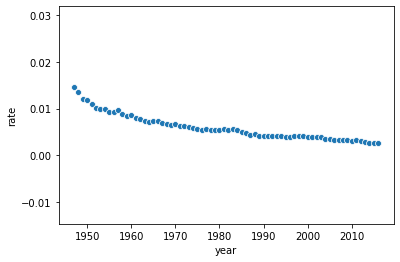

In [3]:
sns.scatterplot(df_50["year"],df_50["rate"])

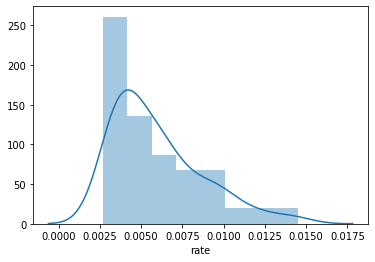

In [4]:
sns.distplot(df_50["rate"])

In [5]:
rate = df_50["rate"].to_numpy().reshape(-1,1)
year = df_50["year"].to_numpy().reshape(-1,1)

In [6]:
sa_1 = CWGP("box_cox",n=2)
sal_1 = CWGP("sal",n=3)

[  0.97036968 265.13535479]


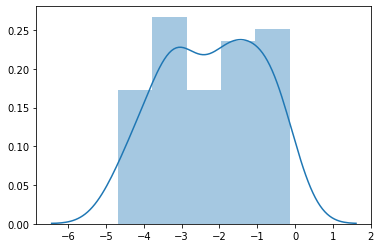

In [8]:
p_1 = sa_1.fit(rate).x
print(p_1)
x_1, d = sa_1.phi.comp_phi(p_1,rate)
sns.distplot(x_1)

 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:divide by zero encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning:invalid value encountered in subtract
 /home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning:invalid value encountered in det
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning:invalid value encountered in less
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning:invalid value encountered in greater
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning:invalid value encountered in greater_equal


[ 18.04770841  36.07282486   2.21652449   2.31245696 -16.81897441
  43.87031585   6.50329804  24.08936318   0.92982214   0.12070908
   0.0958605   -2.4190682 ]


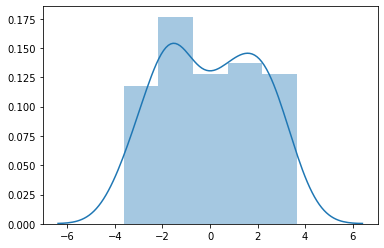

In [9]:
p_2 = sal_1.fit(x_1).x
print(p_2)
x_2, d = sal_1.phi.comp_phi(p_2,x_1)
sns.distplot(x_2)


Name : GP regression
Objective : -398.84001142072077
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat32.variance           |  9.120310481616092e-05  |      +ve      |        
  Mat32.lengthscale        |      28.65518998543007  |      +ve      |        
  Gaussian_noise.variance  |  6.603470821697526e-26  |      +ve      |        


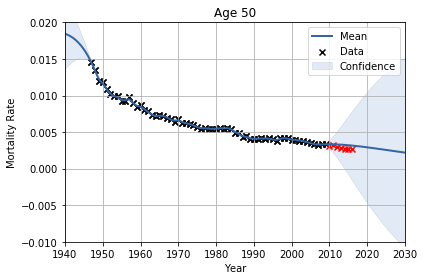

In [10]:
kernel = GPy.kern.Matern32(1)

ratio = 0.9
length = len(df_50)
train = int(ratio*length)
train_up, train_low = train, train-train


model_cwgp = GPy.models.GPRegression(df_50.year[:, None][train_low:train_up], df_50.rate[:, None][train_low:train_up], kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black')
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red')

plt.title('Age ' + str(50))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.ylim([-0.01,0.02])

plt.grid(True)
plt.show()

In [11]:
data = []
for i in range(2010,2017):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)
mean = tr_data[:,:,0]

n = 7
rmse = np.sqrt(np.sum((np.ravel(mean)-df_50.rate[train_up:])**2)/n)
mae = np.sum(np.abs(np.ravel(mean)-df_50.rate[train_up:]))/n

print(rmse,mae)

0.00038264935165624296 0.0003462915475904032



Name : GP regression
Objective : -2.590773811322773
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  Mat32.variance           |    5.4357913074454585  |      +ve      |        
  Mat32.lengthscale        |    23.445730065058825  |      +ve      |        
  Gaussian_noise.variance  |  0.017382752338123413  |      +ve      |        


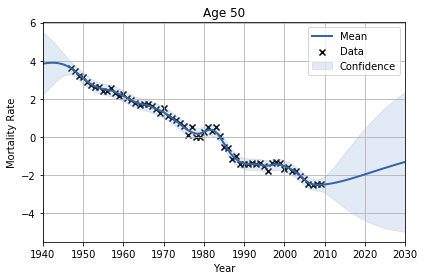

In [12]:
model_cwgp = GPy.models.GPRegression(df_50.year[:, None][train_low:train_up], x_2[train_low:train_up], kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])

plt.title('Age ' + str(50))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')

plt.grid(True)
plt.show()

In [13]:
data = []
for i in range(1940,2031):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)


In [14]:
CI = 1.96
mean = tr_data[:,:,0]
var_upper = mean + CI*np.sqrt(tr_data[:,:,1])
var_lower = mean - CI*np.sqrt(tr_data[:,:,1])
predict_mean = sal_1.phi.inv_comp_phi(p_2,mean)
predict_mean = sa_1.phi.inv_comp_phi(p_1,predict_mean)
predict_var_upper = sal_1.phi.inv_comp_phi(p_2,var_upper)
predict_var_upper = sa_1.phi.inv_comp_phi(p_1,predict_var_upper)
predict_var_lower = sal_1.phi.inv_comp_phi(p_2,var_lower)
predict_var_lower = sa_1.phi.inv_comp_phi(p_1,predict_var_lower)

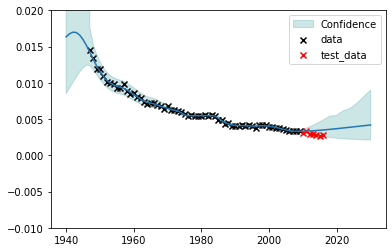

In [15]:
plt.fill_between(np.linspace(1940,2030,91),np.ravel(predict_var_upper),np.ravel(predict_var_lower),color=(0,0.5,0.5,0.2), label="Confidence")
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black', label="data")
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red', label="test_data")
plt.legend()
plt.ylim([-0.01,0.02])
plt.plot(np.linspace(1940,2030,91),predict_mean, label="mean")


In [17]:

rmse = np.sqrt(np.sum((np.ravel(predict_mean[70:77])-df_50.rate[train_up:])**2)/n)
mae = np.sum(np.abs(np.ravel(predict_mean[70:77])-df_50.rate[train_up:]))/n

rmse,mae

(0.0005450694035074936, 0.00047613035348027273)